In [45]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

NUM_CLASSES = 3
CHANNELS_D = 3
IMG_SIZE = 256
device = "cuda" if torch.cuda.is_available() else "cpu"
data_dir = "~/Documents/datasets/archive/caltech101_classification/"
classes = ["Motorcycle", "Airplane", "Schooner"]

In [30]:
# for simplicity, just normalize whole dataset instead of each class label
def norm_transforms(dir):
    transform = transforms.Compose(
        [transforms.Resize((IMG_SIZE, IMG_SIZE)), transforms.ToTensor()]
    )
    dataset = datasets.ImageFolder(root=dir, transform=transform)
    # concat image data (CxWxH) in tensor, discard labels
    imgs = torch.stack([img_t for img_t, _ in dataset], dim=3)
    # flatten the three channels of all images and take the mean
    mean = np.array([m for m in imgs.view(3, -1).mean(dim=1)])
    std = np.array([s for s in imgs.view(3, -1).std(dim=1)])

    norm = transforms.Normalize(
        mean = mean,
        std = std
    )
    unorm = transforms.Normalize(
        mean = -(mean/std),
        std = (1 / std)
    )
    
    return norm, unorm

norm, unorm = norm_transforms(data_dir)

In [31]:
def load_data(dir):
    transform = transforms.Compose(
        [
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor(),
            norm,
        ]
    )
    dataset = datasets.ImageFolder(root=dir, transform=transform)

    train_size = int(0.6 * len(dataset))
    test_val_size = len(dataset) - train_size
    train_data, test_val_data = torch.utils.data.random_split(
        dataset, [train_size, test_val_size]
    )

    val_size = int(0.5 * len(test_val_data))
    test_size = len(test_val_data) - val_size
    val_data, test_data = torch.utils.data.random_split(
        test_val_data, [val_size, test_size]
    )
    return train_data, val_data, test_data
    
train_data, val_data, test_data = load_data(
    "~/Documents/datasets/archive/caltech101_classification/"
)

### My attempt at CNNs

In [4]:
class CNN(nn.Module):
    def __init__(self, num_layers, expansion):
        super().__init__()
        self.fcl, self.net = self._gen_layers(num_layers, expansion)
        self.classifier = self._classifier()
        
    def _gen_layers(self, num_layers, expansion):
        layers = []
        in_channels = CHANNELS_D
        
        # use batchnorm to prevent over/under shooting
        for i in range(num_layers):
            out_channels = expansion(in_channels)
            # out_channels = expansion * in_channels
            layers += [
                nn.Conv2d(in_channels, out_channels, kernel_size=5, padding=2)
            ]
            layers += [nn.ReLU(), nn.BatchNorm2d(out_channels, affine=False)]
            layers += [nn.MaxPool2d(2, 2)]
            in_channels = out_channels
        fcl = ((IMG_SIZE // (2 ** num_layers)) ** 2) * in_channels
        
        return fcl, nn.Sequential(*layers)

    def _classifier(self):
        layers = []
        layers += [
            nn.Flatten(1),
            nn.BatchNorm1d(self.fcl, affine=False),
            nn.Linear(self.fcl, 256)
        ]
        layers += [nn.ReLU(), nn.Linear(256, NUM_CLASSES), nn.ReLU()]
        
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.classifier(self.net(x))

In [33]:
def eval(model, data):
    with torch.no_grad():
        correct = 0

        for (img, label) in data:
            img_input = img.to(device).unsqueeze(0)
            pred = model(img_input)
            _, pred = torch.max(pred.squeeze(), 0)
            pred = pred.to("cpu")
            correct += pred.item() == label
        return correct, round((correct / len(data) * 100), 3)

In [15]:
def train(model, train_data, batch, epochs, lr):
    loader = DataLoader(train_data, batch_size=batch, shuffle=True, num_workers=2)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)

    epoch_data = []
    for epoch in range(epochs + 1):
        running_loss = 0.0
        for i, (imgs, labels) in enumerate(loader):
        # for i, (imgs, labels) in enumerate(tqdm(loader)):
            inputs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        model.eval()
        _, train_acc = eval(model, train_data)
        _, val_acc = eval(model, val_data)
        model.train()
        
        print(f'epoch: {epoch + 1} loss: {running_loss / batch:.6f}')
        epoch_data.append((epoch, float(f"{(running_loss / batch):.6f}"), train_acc, val_acc))
        running_loss = 0.0
    
    return epoch_data

def save(model, path):
    torch.save(model.state_dict(), path)

In [7]:
def sample(model, test_data):
    with torch.no_grad():
        figure = plt.figure(figsize=(10, 8))
        cols, rows = 4, 4
        correct = 0

        for i in range(1, cols * rows + 1):
            rand = torch.randint(len(test_data), size=(1,)).item()
            img, label = test_data[rand]
            img_input = img.to(device).unsqueeze(0)

            figure.add_subplot(rows, cols, i)
            img = unorm(img)
            npimg = np.transpose(img.numpy(), (1, 2, 0))

            plt.title(f"({i}) {classes[label]}")
            plt.axis("off",)
            plt.imshow((npimg * 255).astype(np.uint8))

            pred = model(img_input).to('cpu')

            _, pred = torch.max(pred.squeeze(), 0)
    
            print(f"({i}) Prediction: {classes[pred.item()]}, Actual: {classes[label]}")
            correct += classes[pred.item()] == classes[label]
        
        print(f"\n {correct} / {cols * rows} correct -> {correct / (cols * rows) * 100} %")
        plt.show()

In [8]:
expansions = []
lrs = [1e-4, 2e-3, 35e-4, 0.01]
num_layers = 4
batch_size = 128
num_epochs = 50
# recursive expressions to use for expanding feature map from conv layer (number of kernels)
expansions.append(lambda x: x + 13)
expansions.append(lambda x: x*2 if x < 20 else x + (x // 2))
expansions.append(lambda x: x*3 if x < 50 else x + (x // 6))


In [ ]:
# use data loader for eval func to use batches
# speed up train time

runs = []
for n in range(num_layers):
    for expr in expansions:
        model = CNN(n + 1, expr).to(device)
        epoch_data = train(model, train_data, batch=batch_size, epochs=num_epochs, lr=lrs[n])
        print("evaluating...")
        model.eval() # set eval for batch norm bc batch size is only 1
        _, accuracy = eval(model, val_data)
        runs.append((n, expr, accuracy, epoch_data))
        del model

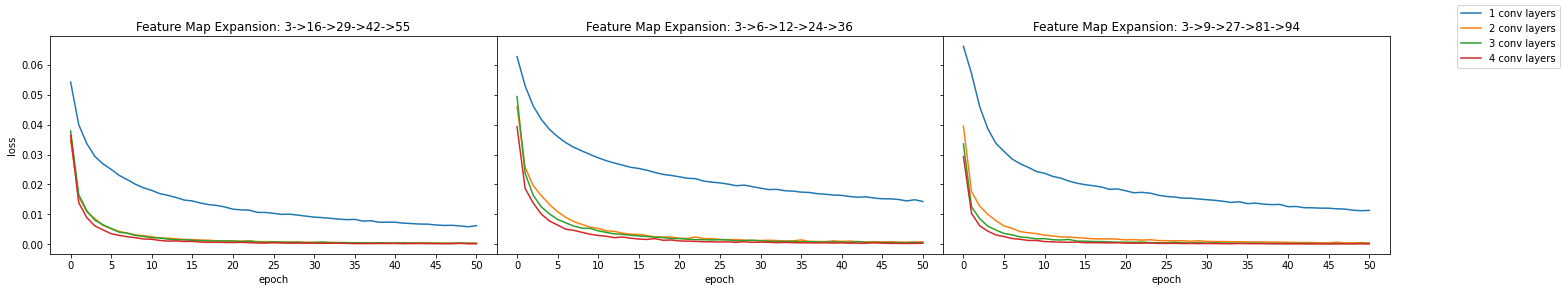

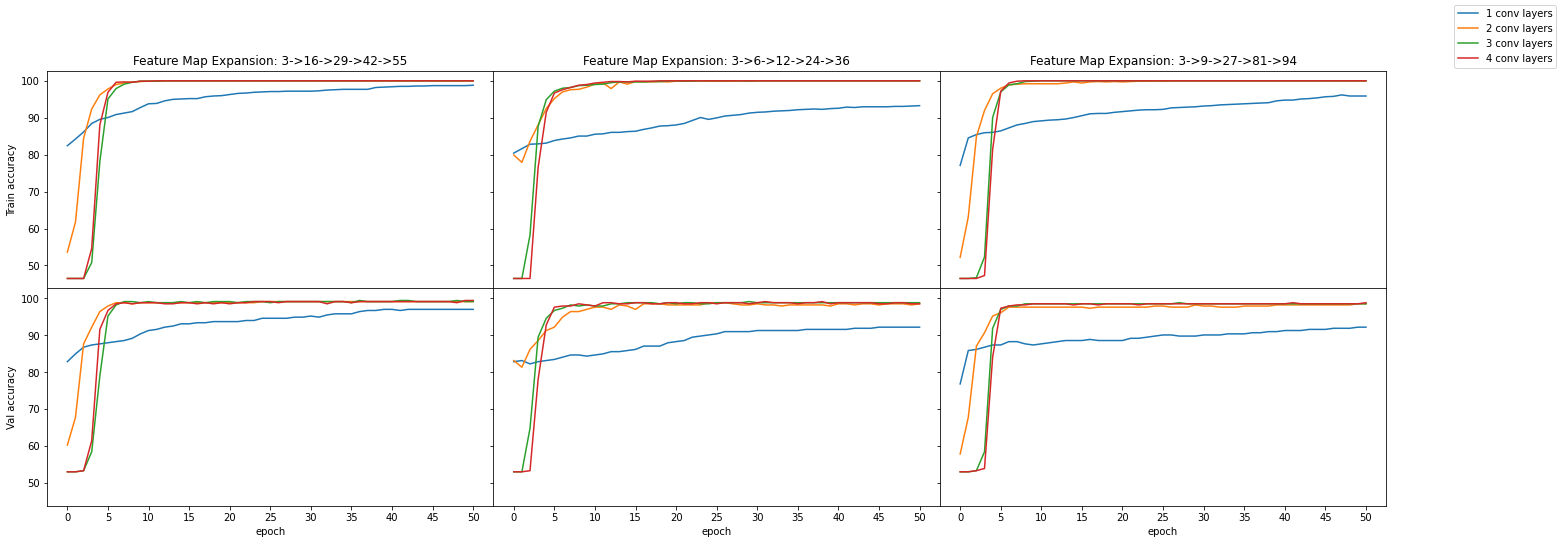

In [14]:
def str_conv_seq(expr, n_lay):
    prior = CHANNELS_D
    conv_seq = str(prior)
    for i in range(n_lay + 1):
        prior = expr(prior)
        conv_seq += f"->{str(prior)}"
    return conv_seq

def plot_losses(runs):
    fig, axs = plt.subplots(1, len(expansions), figsize=(24,4),
        gridspec_kw={'wspace': 0}, sharey=True)

    axs[0].set(ylabel="loss")
    for (n_lay, expr, accuracy, epoch_data) in runs:
        c = expansions.index(expr)
        conv_seq = str_conv_seq(expr, n_lay)
        train_info = [*zip(*epoch_data)]
        axs[c].set_title("Feature Map Expansion: " + conv_seq)
        if c == len(expansions) - 1:
            axs[c].plot(train_info[0], train_info[1], label=f"{n_lay + 1} conv layers")    
        else:
            axs[c].plot(train_info[0], train_info[1])

    for ax in axs:
        ax.set(xlabel="epoch")
        ax.set_xticks(np.arange(0, num_epochs + 1, 5))

    lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    lines, labels = [sum(l_l, []) for l_l in zip(*lines_labels)]
    fig.legend(lines, labels)

def plot_accuracies(runs):
    fig, axs = plt.subplots(2, len(expansions), figsize=(24,8),
        gridspec_kw={'hspace': 0, 'wspace': 0}, sharey=True)

    axs[0, 0].set(ylabel='Train accuracy')
    axs[1, 0].set(ylabel='Val accuracy')
    for (n_lay, expr, accuracy, epoch_data) in runs:
        c = expansions.index(expr)
        conv_seq = str_conv_seq(expr, n_lay)
        train_info = [*zip(*epoch_data)]

        if c == len(expansions) - 1:
            axs[0, c].plot(train_info[0], train_info[2], label=f"{n_lay + 1} conv layers") 
        else:
            axs[0, c].plot(train_info[0], train_info[2])
        
        axs[0, c].set_title("Feature Map Expansion: " + conv_seq)
        axs[1, c].plot(train_info[0], train_info[3])

    for ax in axs[1, :]:
        ax.set(xlabel="epoch")
        ax.set_xticks(np.arange(0, num_epochs + 1, 5))

    lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    lines, labels = [sum(l_l, []) for l_l in zip(*lines_labels)]
    fig.legend(lines, labels)

  
plot_losses(runs)
plot_accuracies(runs)


In [13]:
def print_acc(runs):
    for (n_lay, expr, accuracy, _) in runs:
        conv_seq = str_conv_seq(expr, n_lay)
        print(f"{conv_seq} accuracy: {accuracy}%")
        
print_acc(runs)

3->16 accuracy: 96.988%
3->6 accuracy: 92.169%
3->9 accuracy: 92.169%
3->16->29 accuracy: 99.096%
3->6->12 accuracy: 98.494%
3->9->27 accuracy: 98.494%
3->16->29->42 accuracy: 99.096%
3->6->12->24 accuracy: 98.795%
3->9->27->81 accuracy: 98.494%
3->16->29->42->55 accuracy: 99.398%
3->6->12->24->36 accuracy: 98.494%
3->9->27->81->94 accuracy: 98.795%


In [88]:
def count_params(model: nn.Module):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def get_incorrect(model, data):
    with torch.no_grad():
        incorrect = []
        for (img, label) in data:
            img_input = img.to(device).unsqueeze(0)
            pred = model(img_input)
            _, pred = torch.max(pred.squeeze(), 0)
            pred = pred.to("cpu")
            if pred.item() != label:
                incorrect.append((img, label, pred))
                
    return incorrect

def show_incorrect(incorrect):
    figure = plt.figure(figsize=(10, 8))
    cols, rows = 2, len(incorrect) // 2 + 1
    correct = 0

    for i, (img, label, pred_label) in enumerate(incorrect):
        figure.add_subplot(rows, cols, i + 1)
        img = unorm(img).to("cpu")
        npimg = np.transpose(img.numpy(), (1, 2, 0))
        plt.title(f"actual: {classes[label]} pred: {classes[pred_label]}")
        plt.axis("off",)
        plt.imshow((npimg * 255).astype(np.uint8))

In [ ]:
model.eval()
correct, acc = eval(model, val_data)
show_incorrect(get_incorrect(model, val_data))
print(f"{correct} out of {len(val_data)} correct \
    accuracy: {acc}%")

### save best model here 

### VGGNet implementation

paper: https://arxiv.org/abs/1409.1556

![vgg_arch.png](./imgs/vgg_arch.png)

- Conv layers use 3x3 kernel with the exception of C
- C uses 1x1 kernel at the end of the last three sections 
- Padding used on convolutions to maintain dimensionality of input
- Maxpool between each section of conv layers uses 2x2 for kernel and stride
- Maxpool is followed by ReLU

In [7]:
class VGG(nn.Module):
    def __init__(self, net_config=None):
        super().__init__()
        self.configs = {         # not including A-LRN for convenience
            'A': [1, 1, 2, 2, 2],
            'B': [2, 2, 2, 2, 2],
            'C': [2, 2, 3, 3, 3],
            'D': [2, 2, 3, 3, 3],
            'E': [2, 2, 4, 4, 4]
        }
        if net_config:
            self.fcl, self.net = self._gen_layers(net_config)
            self.classifier = self._classifier()

    def _gen_layers(self, net_config):
        layers = []
        num_layers = self.configs[net_config]
        in_channels, out_channels = CHANNELS_D, 64

        for i, n in enumerate(num_layers):
            for j in range(1, n + 1):
                c_trans = net_config == "C" and j == n and out_channels >= 256
                (kernel, pad) = (1, 0) if c_trans else (3, 1)
                layers.append(nn.Conv2d(
                        in_channels, out_channels, kernel, padding=pad
                    )
                )
                layers.append(nn.BatchNorm2d(out_channels, affine=False))
                layers.append(nn.ReLU())
                in_channels = out_channels
            layers.append(nn.MaxPool2d(2, 2))
            if out_channels < 512:
                out_channels *= 2
        fcl = ((IMG_SIZE // (2 ** 5)) ** 2) * in_channels

        return fcl, nn.Sequential(*layers)

    def _classifier(self):
        layers = []
        layers += [
            nn.Flatten(1),
            nn.Linear(self.fcl, 4096), nn.ReLU(),
            nn.Linear(4096, 4096), nn.ReLU(),
            nn.Linear(4096, NUM_CLASSES)
        ]

        return nn.Sequential(*layers)
        
    def forward(self, x):
        return self.classifier(self.net(x))

In [ ]:
runs_vgg = []
batch_size = 32
num_epochs = 50
lr = 1e-3

for vgg_arch in VGG().configs.keys():
    model = VGG(vgg_arch).to(device)
    epoch_data = train(model, train_data, batch_size, num_epochs, lr)
    print("evaluating...")
    model.eval() # set eval for batch norm bc batch size is only 1
    _, accuracy = eval(model, val_data)
    runs_vgg.append((n, vgg_arch, accuracy, epoch_data))
    del model

### GoogLeNet implementation

paper: https://arxiv.org/abs/1409.4842.pdf

`Architecture`

![google_arch.png](./imgs/google_arch.png)

`Inception block`

![inception_block.png](./imgs/inception_block.png)

- Note: Model had softmax output layer

In [23]:
class Conv(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super().__init__()
        self.conv  = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, **kwargs),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.conv(x)

In [24]:
class Inception(nn.Module):
    def __init__(self, in_channels, _1x1, _3x3r, _3x3, _5x5r, _5x5, pool):
        super().__init__()
        self.inc_block = self._gen_branches(
            in_channels, _1x1, _3x3r, _3x3, _5x5r, _5x5, pool
        )

    def _gen_branches(self, in_channels, _1x1, _3x3r, _3x3, _5x5r, _5x5, pool):
        b1 = nn.Sequential(Conv(in_channels, _1x1, kernel_size=1).to(device))
        b2 = nn.Sequential(
            Conv(in_channels, _3x3r, kernel_size=1).to(device),
            Conv(_3x3r, _3x3, kernel_size=3, padding=1).to(device)
        )
        b3 = nn.Sequential(
            Conv(in_channels, _5x5r, kernel_size=1).to(device),
            Conv(_5x5r, _5x5, kernel_size=5, padding=2).to(device)
        )
        b4 = nn.Sequential(
            nn.MaxPool2d(3, 1, 1),
            Conv(in_channels, pool, kernel_size=1).to(device)
        )

        return [b1, b2, b3, b4]

    def forward(self, x):
        return torch.cat([b(x) for b in self.inc_block], dim=1)

In [46]:
class GoogLeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = self._gen_layers()
        self.classifier = self._classifier()

    def _gen_layers(self):
        layers = [
            Conv(3, 64, kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(3, 2, 1),
            Conv(64, 192, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(3, 2, 1),
            Inception(192, 64, 96, 128, 16, 32, 32),
            Inception(256, 128, 128, 192, 32, 96, 64),
            nn.MaxPool2d(3, 2, 1),
            Inception(480, 192, 96, 208, 16, 48, 64),
            Inception(512, 160, 112, 224, 24, 64, 64),
            Inception(512, 128, 128, 256, 24, 64, 64),
            Inception(512, 112, 144, 288, 32, 64, 64),
            Inception(528, 256, 160, 320, 32, 128, 128),
            nn.MaxPool2d(3, 2, 1),
            Inception(832, 256, 160, 320, 32, 128, 128),
            Inception(832, 384, 192, 384, 48, 128, 128),
        ]

        return nn.Sequential(*layers)

    def _classifier(self):
        feature_map_dim = IMG_SIZE // (2 ** 5)
        layers = [
            nn.AvgPool2d(feature_map_dim, 1),
            nn.Flatten(1),
            nn.Dropout(0.4),
            nn.Linear(1024, NUM_CLASSES)
        ]

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.layers(x)
        x = self.classifier(x)
        
        return x


In [47]:
def test():
    runs_google = []
    batch_size = 32
    num_epochs = 50
    lr = 1e-3

    model = GoogLeNet().to(device)
    epoch_data = train(model, train_data, batch_size, num_epochs, lr)
    print("evaluating...")
    model.eval() # set eval for batch norm bc batch size is only 1
    _, accuracy = eval(model, val_data)
    runs_google.append((n, "GoogLeNet", accuracy, epoch_data))
    del model

test()

### ? ResNet implementation
paper: https://arxiv.org/abs/1512.03385

### Overall evaluation

### Conclusion